In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x


x = make_data(1000)

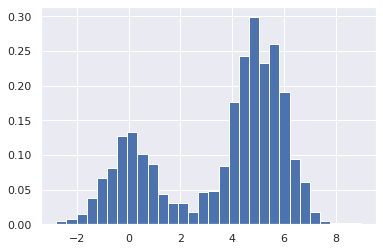

In [3]:
# данные сгенерированные из двух нормального распределения
hist = plt.hist(x, bins=30, density=True)

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()
# общая площадь под гистограммой равна 1

1.0

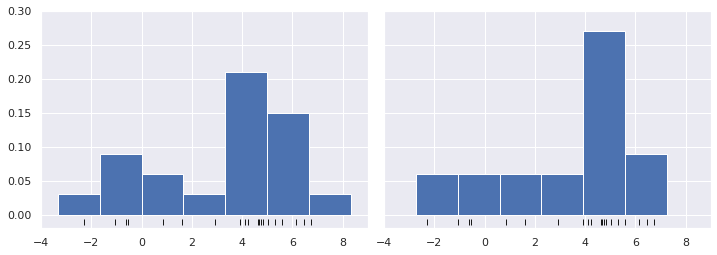

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim': (-4, 9),
                                   'ylim': (-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)
# Проблема гистограмм: различная интерпретация в зависимости от расположения интервалов

(-0.2, 8.0)

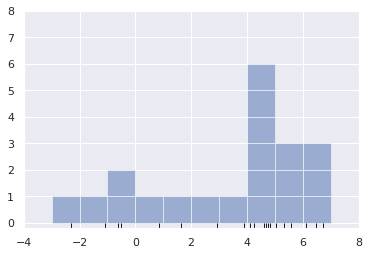

In [6]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)
# Гистограмма как «стопки» блоков

(-4.0, 8.0, -0.2, 8.0)

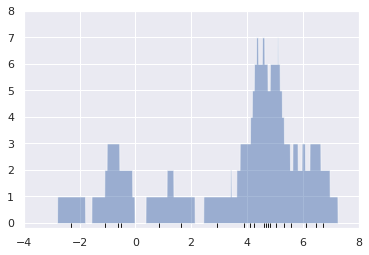

In [7]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8])
# Гистограмма с центрированием блоков по отдельным точкам — пример ядерной оценки плотности распределения

(-4.0, 8.0, -0.2, 5.0)

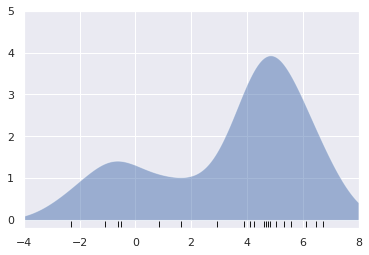

In [8]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 5])
# Ядерная оценка плотности распределения с Гауссовым ядром

(-0.02, 0.22)

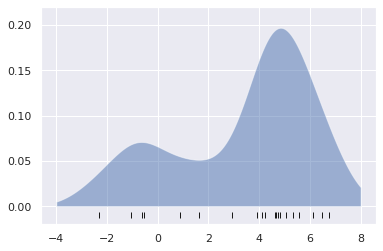

In [9]:
from sklearn.neighbors import KernelDensity
# Создание экземпляра модели KDE и ее обучение
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])
# score_samples возвращает логарифм плотности
# распределения вероятности
logprob = kde.score_samples(x_d[:, None])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)
# Ядерная оценка плотности, вычисленная с помощью библиотеки Scikit-Learn

In [10]:
# поиск оптимальной ширины ядра путем кросс валидации
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None])

GridSearchCV(cv=LeaveOneOut(), estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.305385...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])})

In [11]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

In [12]:
from sklearn.datasets import fetch_species_distributions
data = fetch_species_distributions()
# Получаем матрицы/массивы идентификаторов и местоположений животных
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

In [13]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

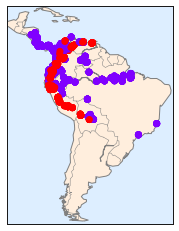

In [14]:
from mpl_toolkits.basemap import Basemap

xgrid, ygrid = construct_grids(data)
# Рисуем береговые линии с помощью Basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)
# Отображаем места, где наблюдались особи
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True)

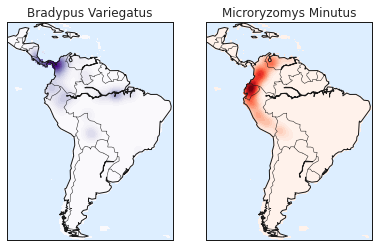

In [15]:
# Настраиваем сетку данных для контурного графика
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T 
xy = np.radians(xy[land_mask])
# Создаем два графика друг возле друга
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']
for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    # Рисуем береговые линии с помощью Basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    # Формируем сферическую ядерную оценку плотности распределения
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))
    # Выполняем расчеты только на поверхности Земли:
    # -9999 соответствует океану
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    # Рисуем изолинии плотности
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

# Bayes classifier using KDE

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """ Байесовская порождающая классификация на основе метода KDE
        Параметры
        ----------
        bandwidth : float
        Ширина ядра в каждом классе
        kernel : str
        Название ядра, передаваемое функции KernelDensity
    """

    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [17]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
digits = load_digits()
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)
scores = grid.cv_results_['mean_test_score']

{'bandwidth': 6.135907273413174}
accuracy for KDE Bayes = 0.9677298050139276


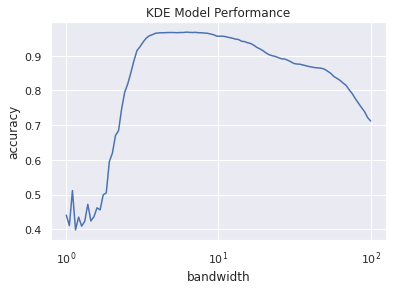

In [22]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth') # Ширина ядра
plt.ylabel('accuracy') # Точность
plt.title('KDE Model Performance') # Эффективность модели KDE
print(grid.best_params_)
print('accuracy for KDE Bayes =', grid.best_score_)

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
score = cross_val_score(GaussianNB(), digits.data, digits.target).mean()
print('accuracy for GaussianNB = ', score)

accuracy for GaussianNB =  0.8069281956050759
